In [17]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [18]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Prueba Completa

In [19]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(count=3,
                         label="3y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(count=10,
                         label="10y",
                         step="year",
                         stepmode="backward"),
                    dict(count=20,
                         label="20y",
                         step="year",
                         stepmode="backward"),
                    dict(count=30,
                         label="30y",
                         step="year",
                         stepmode="backward"),
                    dict(count=50,
                         label="50y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Indice de producción"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()


Rolling Forecast (ARIMA (1, 0, 13)):   0%|          | 0/13 [00:00<?, ?it/s]

Rolling Forecast (ARIMA (1, 0, 13)): 100%|██████████| 13/13 [00:26<00:00,  2.02s/it]


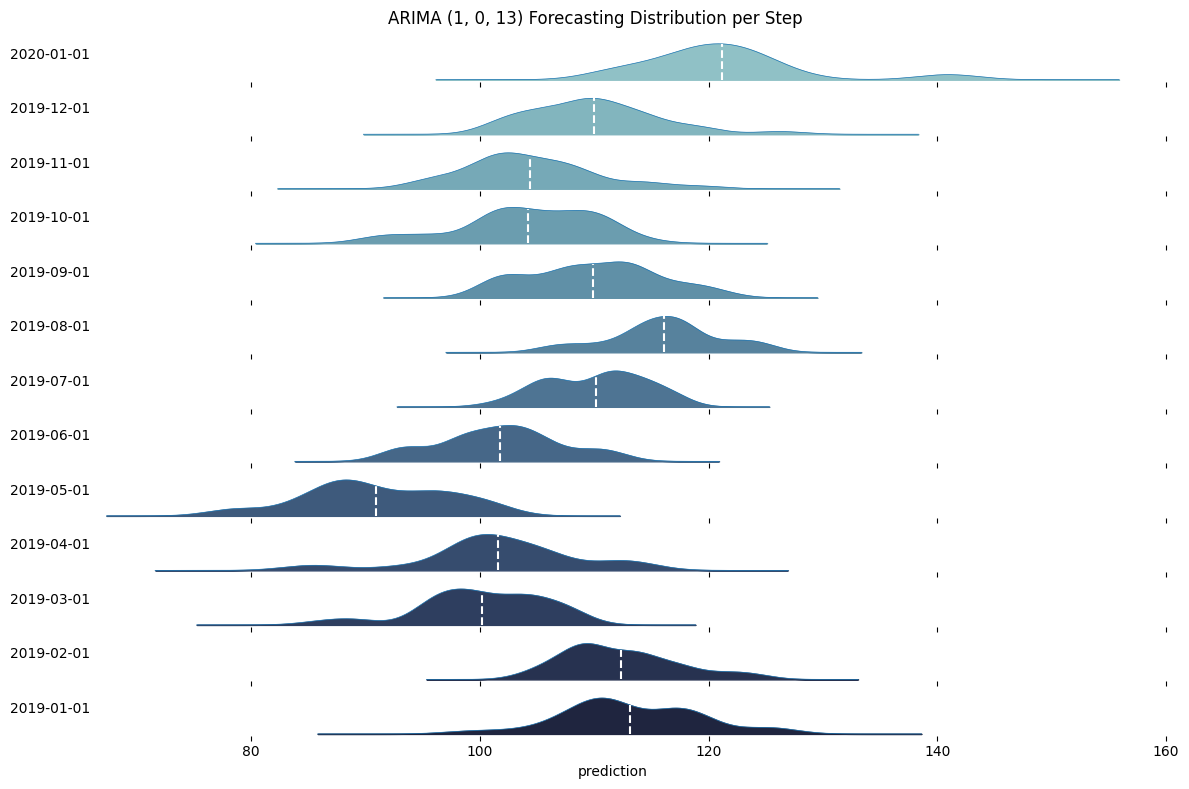

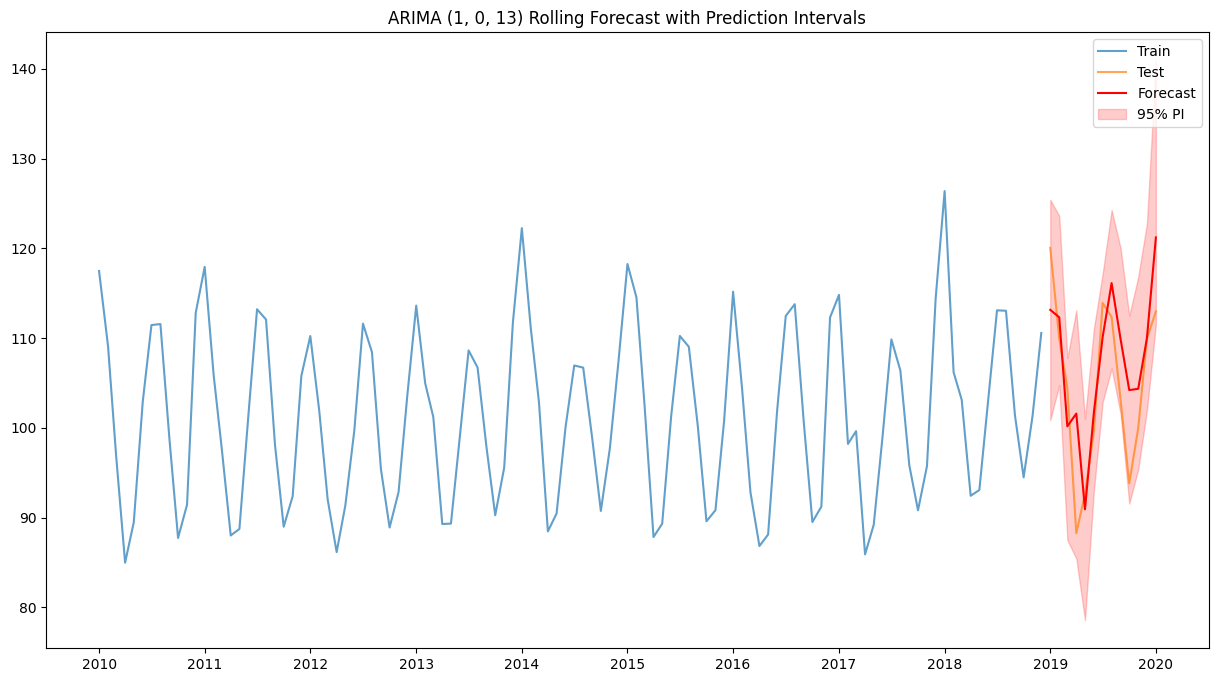

CRPS Score for ARIMA (1, 0, 13): 4.719940239642966


Rolling Forecast (ARIMA (2, 0, 2)): 100%|██████████| 13/13 [00:03<00:00,  3.88it/s]


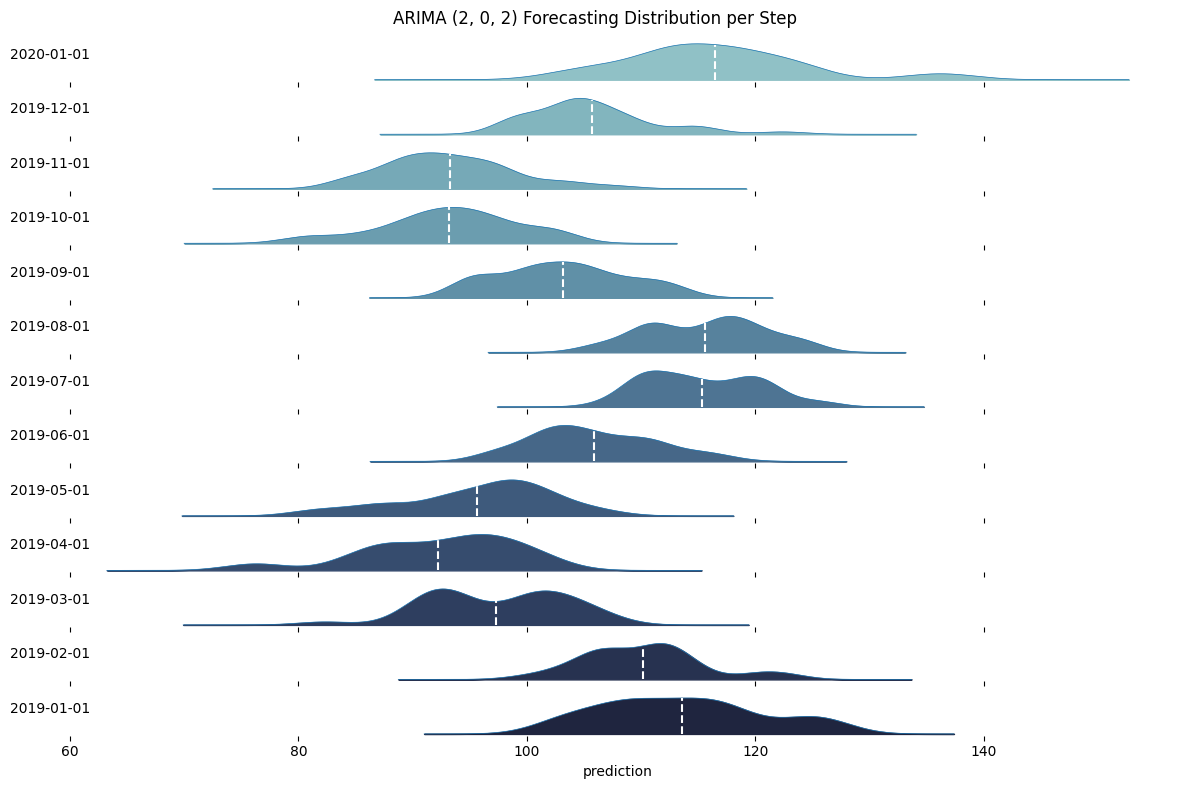

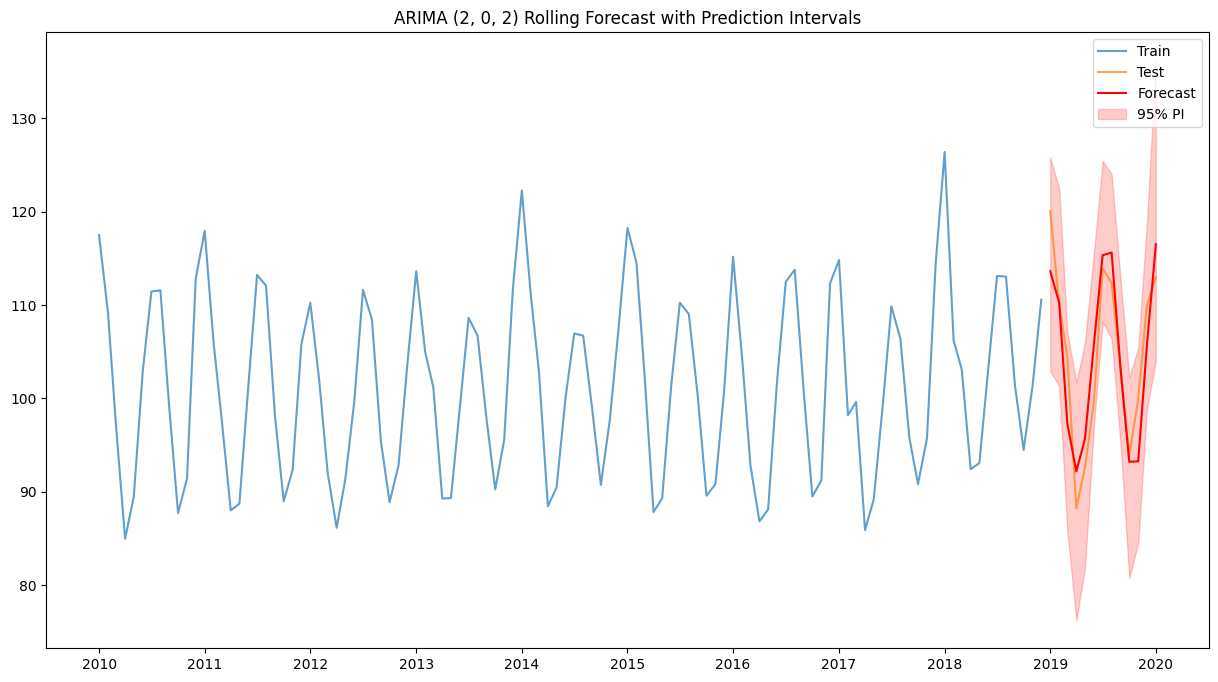

CRPS Score for ARIMA (2, 0, 2): 4.681002496127946


Rolling Forecast (ARIMA (1, 0, 1)): 100%|██████████| 13/13 [00:01<00:00, 10.29it/s]


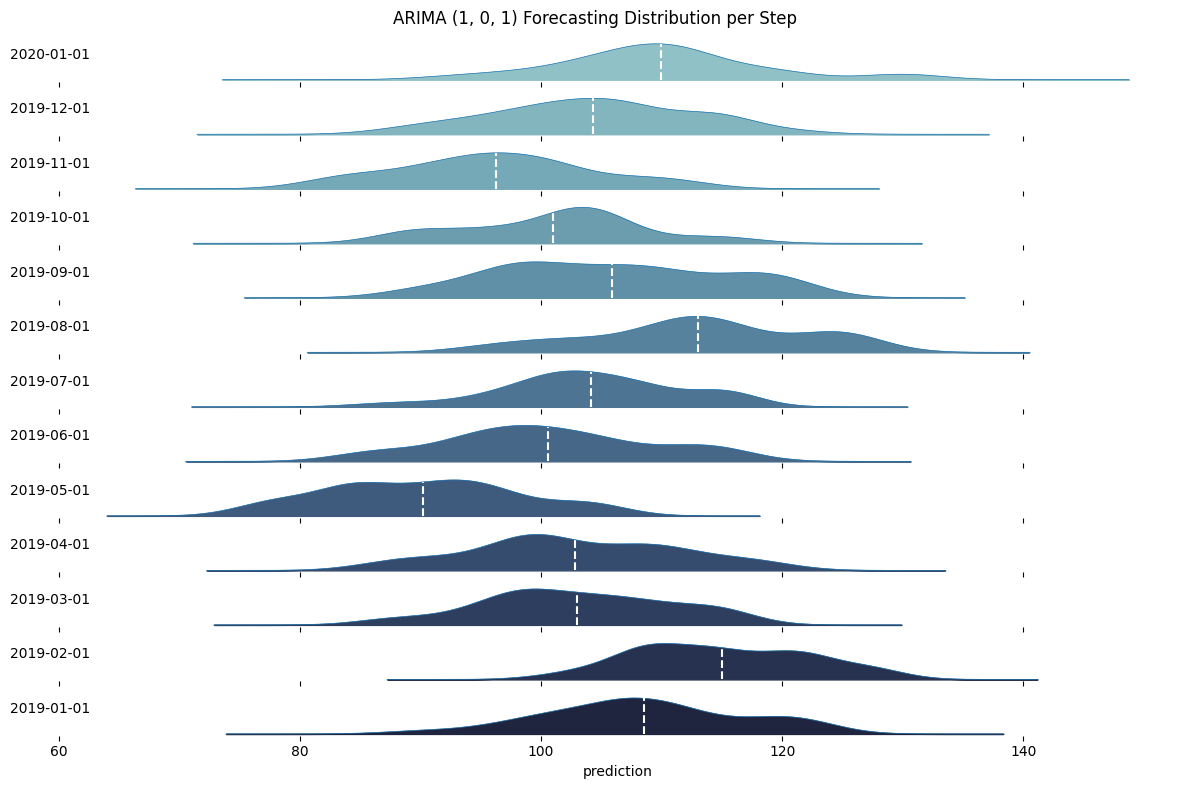

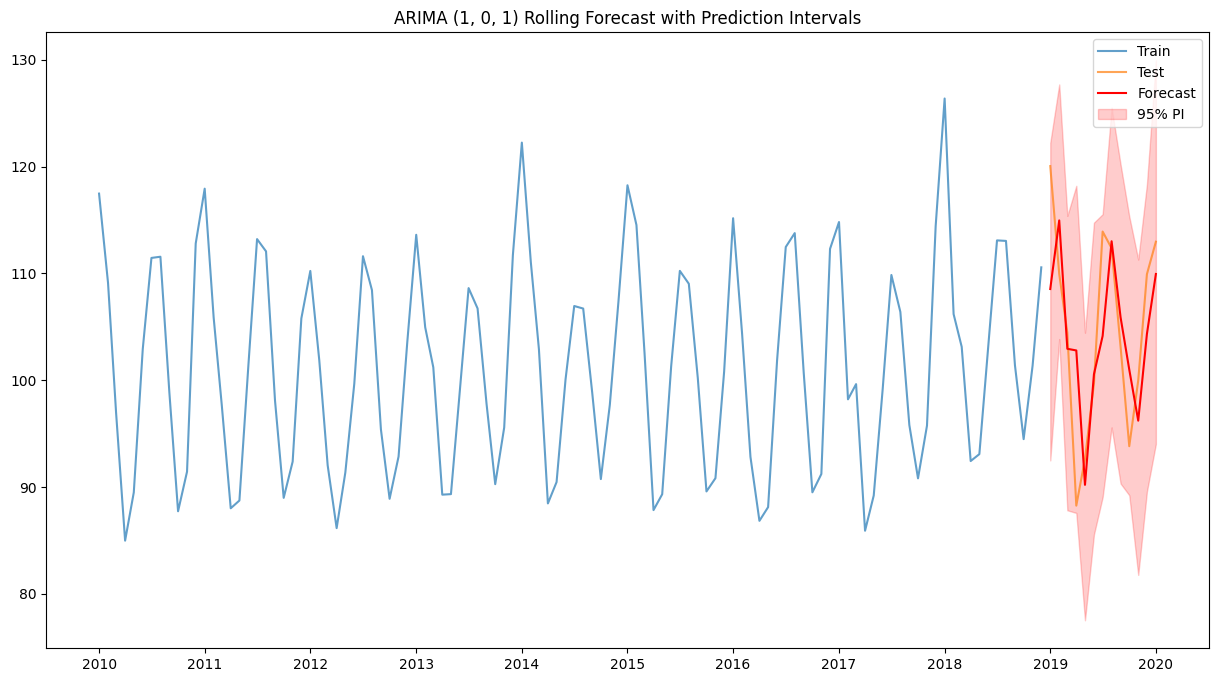

CRPS Score for ARIMA (1, 0, 1): 4.522865809800364
   Model       Order      CRPS
0  ARIMA   (1, 0, 1)  4.522866
1  ARIMA   (2, 0, 2)  4.681002
2  ARIMA  (1, 0, 13)  4.719940


In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any
from tqdm import tqdm
import scoringrules as sr  # Make sure you have this library installed

def fit_arima_model(train_data, order):
    model = ARIMA(train_data, order=order, freq='MS')  # Order is now a parameter
    return model.fit()

def predict_bootstrapping(model, train_data, steps=1, n_boot=500, random_state=123):
    predictions = model.forecast(steps=steps)
    residuals = model.resid
    
    boot_predictions = np.full((steps, n_boot), np.nan)
    rng = np.random.default_rng(seed=random_state)
    
    for i in range(n_boot):
        sample_residuals = rng.choice(residuals, size=steps, replace=True)
        boot_predictions[:, i] = predictions + sample_residuals
    
    return pd.DataFrame(boot_predictions, columns=[f"pred_boot_{i}" for i in range(n_boot)],
                        index=pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=steps, freq='MS'))

def rolling_forecast_with_bootstrapping(train, test, window_size=24, n_boot=500, order=(1, 0, 13)):
    all_bootstrap_predictions = []
    
    for i in tqdm(range(len(test)), desc=f"Rolling Forecast (ARIMA {order})"):
        train_window = pd.concat([train, test.iloc[:i]])
        model = fit_arima_model(train_window.iloc[-window_size:], order=order)
        bootstrap_predictions = predict_bootstrapping(model, train_window.iloc[-window_size:], steps=1, n_boot=n_boot)
        all_bootstrap_predictions.append(bootstrap_predictions)
    
    return pd.concat(all_bootstrap_predictions)

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 model_order: tuple,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')

    fig.subplots_adjust(hspace=-0)
    model_title = f"ARIMA {model_order} Forecasting Distribution per Step"
    fig.suptitle(model_title)
    return fig

def plot_forecast_with_pi(train, test, forecasts, lower_pi, upper_pi, model_order):
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train, label='Train', alpha=0.7)
    plt.plot(test.index, test, label='Test', alpha=0.7)
    plt.plot(forecasts.index, forecasts, label='Forecast', color='red')
    plt.fill_between(forecasts.index, lower_pi, upper_pi, color='red', alpha=0.2, label='95% PI')
    plt.title(f'ARIMA {model_order} Rolling Forecast with Prediction Intervals')
    plt.legend()
    plt.savefig(f"forecast_ARIMA_{model_order}.png")
    plt.show()

def calculate_crps(observations, forecast_ensemble):
    crps_values = []
    for i in range(len(observations)):
        obs = np.array([observations[i]])
        fct = forecast_ensemble.iloc[i].values
        crps = sr.crps_ensemble(obs, fct)
        crps_values.append(crps)
    return np.mean(crps_values)

# Load and prepare the data
data = pd.read_csv('../../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

# ARIMA orders to test
orders = [(1, 0, 13), (2, 0, 2), (1, 0, 1)]
results = []

for order in orders:
    # Perform rolling forecast with bootstrapping
    bootstrap_predictions = rolling_forecast_with_bootstrapping(train['IPG2211A2N'], test['IPG2211A2N'], window_size=24, n_boot=100, order=order)
    
    # Plot the prediction distributions
    fig = plot_prediction_distribution(bootstrap_predictions, model_order=order, figsize=(12, 8))
    plt.tight_layout()
    fig.savefig(f"distribution_ARIMA_{order}.png")
    plt.show()
    
    # Calculate forecasts and prediction intervals
    forecasts = bootstrap_predictions.mean(axis=1)
    lower_pi = bootstrap_predictions.quantile(0.025, axis=1)
    upper_pi = bootstrap_predictions.quantile(0.975, axis=1)
    
    # Plot the forecast with prediction intervals
    plot_forecast_with_pi(train['IPG2211A2N'], test['IPG2211A2N'], forecasts, lower_pi, upper_pi, model_order=order)
    
    # Calculate CRPS for the bootstrap predictions
    observed_values = test['IPG2211A2N'].values
    forecast_ensemble = bootstrap_predictions.T
    crps_score = calculate_crps(observed_values, forecast_ensemble)
    print(f"CRPS Score for ARIMA {order}: {crps_score}")
    
    # Append the results to the final table
    results.append(('ARIMA', f"{order}", crps_score))

# Create a table with the results
results_df = pd.DataFrame(results, columns=['Model', 'Order', 'CRPS'])

# Order the table by CRPS descending
results_df = results_df.sort_values(by='CRPS').reset_index(drop=True)

# Display the results table
print(results_df)
